# Mapeo pro-bono: Prototipo 1
Este prototipo busca analizar el impacto de diferentes organizaciones del 3er sector sobre el area metropolitana de Monterrey. En este archivo se explica el proceso por el cual se realizo este mapeo.
## Importar dependencias
El prototipo depende de las librerias de _pandas_ y _geopandas_ para realizar el procseo de mapeo. Tambien se usan partes de la liberia estandar de Python como `re`, que es una libreria de expresiones regulares para facilitar la limpieza de datos.

In [8]:
import pandas as pd
import geopandas as gpd
import re

from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent='probono')

## Importar regiones geograficas
Los archivos `.shp` que se leen a continuacion contienen los AGEBS de cada municipio del Area Metropolitana de Monterrey, excluyendo aquellos que no contengan suficientes AGEBS para su analisis.

Se procede a limpiar el contenido de los archivos para asi terminar con una tabla completa de todos los AGEBS de la ciudad, cada uno con su respectivo codigo, asi como el nombre de su sector. Estos sectores son los definidos anteriormente por GeoSTATS.

In [9]:
regions = [
    gpd.read_file('../data/regions/Apodaca/AgebsDentrodeApodaca.shp').to_crs('WGS 84'),
    gpd.read_file('../data/regions/Escobedo/AgebsDentrodeEscobedo.shp').to_crs('WGS 84'),
    gpd.read_file('../data/regions/Garcia/AgebsDentrodeGarcia.shp').to_crs('WGS 84'),
    gpd.read_file('../data/regions/Juarez/AgebsDentrodeJuarez.shp').to_crs('WGS 84'),
    gpd.read_file('../data/regions/Monterrey/AgebsDentrodeMonterrey.shp').to_crs('WGS 84'),
    gpd.read_file('../data/regions/San Nicolas/AgebsDentroSanNicolas.shp').to_crs('WGS 84'),
    gpd.read_file('../data/regions/San Pedro/AgebsDentrodeSanPedro.shp').to_crs('WGS 84'),
    gpd.read_file('../data/regions/Santa Catarina/AgebsDentrodeSantaCatarina.shp').to_crs('WGS 84')
]

for region in regions:
    region.rename(columns={'Nombre': 'sector_name'}, inplace=True)

guadalupe = gpd.read_file('../data/regions/Guadalupe/Copia de GUADALUPESectores.shp').to_crs('WGS 84')
guadalupe.rename(columns={'Name': 'sector_name'}, inplace=True)
regions.append(guadalupe)

for region in regions:
    region.rename(columns={'clave': 'code'}, inplace=True)

agebs = gpd.GeoDataFrame(
    pd.concat(regions, ignore_index=True) \
        .filter(items=['sector_name', 'code', 'geometry'])
)
agebs

,sector_name,code,geometry
0,Metroplex,1900600010850,"POLYGON ((-100.25504 25.80534, -100.25483 25.8..."
1,Metroplex,1900600012081,"POLYGON ((-100.24877 25.79173, -100.24876 25.7..."
2,Metroplex,1900600010719,"POLYGON ((-100.25893 25.78469, -100.25843 25.7..."
3,Metroplex,1900600010901,"POLYGON ((-100.24887 25.78764, -100.24882 25.7..."
4,Metroplex,1900600011276,"POLYGON ((-100.25602 25.78718, -100.25600 25.7..."
...,...,...,...
3171,Los Faines,NaN,"POLYGON Z ((-100.18882 25.69060 0.00000, -100...."
3172,Polígono 28,NaN,"POLYGON Z ((-100.25274 25.67564 0.00000, -100...."
3173,Camino Real,NaN,"MULTIPOLYGON Z (((-100.22985 25.67113 0.00000,..."
3174,Unidad Modelo,NaN,"POLYGON Z ((-100.21046 25.69415 0.00000, -100...."


A continuación se muestra una visualización de todos los AGEBS, coloreados por el sector al cual pertenecen.

<Axes: >

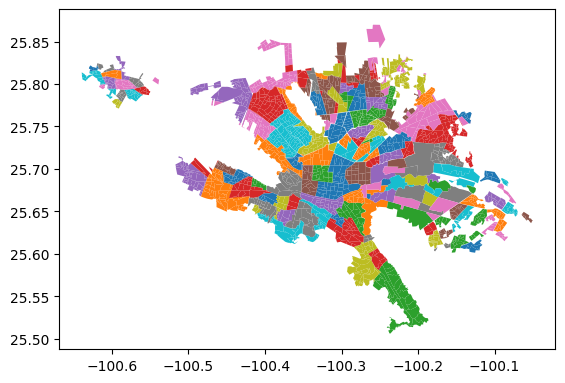

In [10]:
agebs.plot('sector_name')

## Cargar datos del formulario
El formulario de GeoSTATS contiene datos de cada organización que quiere incluirse a este proyecto, y contiene los sectores en los cuales esta organización esta activa. Asimismo, tambien contiene datos especificos por organización, como el ODS al cual atiende, sus niveles de personal, entre otros datos.

In [11]:
survey_answers = pd.read_csv('../data/respuestas_formulario.csv')
survey_answers.rename(columns={
    '2.1 Nombre de la organización/colectivo/iniciativa:': 'name',
    '3.3 Coloca el año en que la organización se constituyó legalmente en Nuevo León': 'legal_incorporation_year',
    '2.2 Coloca el año en que comenzaron actividades en Nuevo León: (independiente del año de constitución legal)': 'start_of_operations_year',
    '9.2 Selecciona el rango aproximado de ingresos totales que obtuvo tu organización/colectivo/iniciativa (incluyendo donativos y otros tipos de ingreso) en el último año aplicable inmediato (en pesos)': 'annual_income',
    '11.1 Selecciona el número de integrantes con nómina o remunerados económicamente con los que cuenta la organización/colectivo/iniciativa al día de hoy:': 'employee_count',
    '11.2 Selecciona el número de personas voluntarias totales (recurrentes o esporádicos) que la organización/colectivo/iniciativa tuvo en el año 2022:': 'volunteer_count',
    'Unnamed: 199': 'target_demographics_and_profiles',
    '11.3 De cada uno de los 17 Objetivos de Desarrollo Sostenible (ODS) de la Agenda 2030 de la ONU, indica la relavancia que tienen para la organización/colectivo/iniciativa: [ODS 1. Fin de la pobreza.]': 'ods1',
    '11.3 De cada uno de los 17 Objetivos de Desarrollo Sostenible (ODS) de la Agenda 2030 de la ONU, indica la relavancia que tienen para la organización/colectivo/iniciativa: [ODS 2. Hambre cero.]': 'ods2',
    '11.3 De cada uno de los 17 Objetivos de Desarrollo Sostenible (ODS) de la Agenda 2030 de la ONU, indica la relavancia que tienen para la organización/colectivo/iniciativa: [ODS 3. Salud y bienestar.]': 'ods3',
    '11.3 De cada uno de los 17 Objetivos de Desarrollo Sostenible (ODS) de la Agenda 2030 de la ONU, indica la relavancia que tienen para la organización/colectivo/iniciativa: [ODS 4. Educación de calidad.]': 'ods4',
    '11.3 De cada uno de los 17 Objetivos de Desarrollo Sostenible (ODS) de la Agenda 2030 de la ONU, indica la relavancia que tienen para la organización/colectivo/iniciativa: [ODS 5. Igualdad de género.]': 'ods5',
    '11.3 De cada uno de los 17 Objetivos de Desarrollo Sostenible (ODS) de la Agenda 2030 de la ONU, indica la relavancia que tienen para la organización/colectivo/iniciativa: [ODS 6. Agua limpia y saneamiento.]': 'ods6',
    '11.3 De cada uno de los 17 Objetivos de Desarrollo Sostenible (ODS) de la Agenda 2030 de la ONU, indica la relavancia que tienen para la organización/colectivo/iniciativa: [ODS 7. Energía asequible y no contaminante]': 'ods7',
    '11.3 De cada uno de los 17 Objetivos de Desarrollo Sostenible (ODS) de la Agenda 2030 de la ONU, indica la relavancia que tienen para la organización/colectivo/iniciativa: [ODS 8. Trabajo decente y crecimiento económico.]': 'ods8',
    '11.3 De cada uno de los 17 Objetivos de Desarrollo Sostenible (ODS) de la Agenda 2030 de la ONU, indica la relavancia que tienen para la organización/colectivo/iniciativa: [ODS 9. industria, innovación e infraestructura.]': 'ods9',
    '11.3 De cada uno de los 17 Objetivos de Desarrollo Sostenible (ODS) de la Agenda 2030 de la ONU, indica la relavancia que tienen para la organización/colectivo/iniciativa: [ODS 10. Reducción de las desigualdades.]': 'ods10',
    '11.3 De cada uno de los 17 Objetivos de Desarrollo Sostenible (ODS) de la Agenda 2030 de la ONU, indica la relavancia que tienen para la organización/colectivo/iniciativa: [ODS 11. Ciudades y comunidades sostenibles.]': 'ods11',
    '11.3 De cada uno de los 17 Objetivos de Desarrollo Sostenible (ODS) de la Agenda 2030 de la ONU, indica la relavancia que tienen para la organización/colectivo/iniciativa: [ODS 12. Producción y consumo responsables.]': 'ods12',
    '11.3 De cada uno de los 17 Objetivos de Desarrollo Sostenible (ODS) de la Agenda 2030 de la ONU, indica la relavancia que tienen para la organización/colectivo/iniciativa: [ODS 13. Acción por el clima.]': 'ods13',
    '11.3 De cada uno de los 17 Objetivos de Desarrollo Sostenible (ODS) de la Agenda 2030 de la ONU, indica la relavancia que tienen para la organización/colectivo/iniciativa: [ODS 14. Vida submarina.]': 'ods14',
    '11.3 De cada uno de los 17 Objetivos de Desarrollo Sostenible (ODS) de la Agenda 2030 de la ONU, indica la relavancia que tienen para la organización/colectivo/iniciativa: [ODS 15. Vida de ecosistemas terrestres.]': 'ods15',
    '11.3 De cada uno de los 17 Objetivos de Desarrollo Sostenible (ODS) de la Agenda 2030 de la ONU, indica la relavancia que tienen para la organización/colectivo/iniciativa: [ODS 16. Paz, justicia e instituciones solidas.]': 'ods16',
    '11.3 De cada uno de los 17 Objetivos de Desarrollo Sostenible (ODS) de la Agenda 2030 de la ONU, indica la relavancia que tienen para la organización/colectivo/iniciativa: [ODS 17. Alianzas para lograr los objetivos.]': 'ods17',
    '10.5 Número exterior': 'ext_number',
    '10.4 Calle': 'street',
}, inplace=True)

survey_answers['address'] = survey_answers[['ext_number', 'street']] \
    .dropna(subset=['ext_number', 'street']) \
    .apply(
    lambda row: f'{re.sub("[^0-9]", "", row.loc["ext_number"])} {row.loc["street"]}, Monterrey, Nuevo León, Mexico',
    axis=1)

survey_answers = survey_answers.dropna(subset=['name'])
survey_answers

,Timestamp,1.1 Nombre(s),1.2 Apellido Paterno,1.3 Apellido Materno,1.4 Puesto actual en la organización/colectivo/iniciativa,1.5 Correo electrónico de contacto,1.6 Teléfono de contacto (fijo o móvil),name,start_of_operations_year,2.3 ¿Actualmente se encuentran constituidos legalmente?,...,15.1 Menciona el nombre del evento o actividad más importante que la organización/colectivo/iniciativa realiza anualmente: \n,15.2 Menciona la fecha (puedes colocar un aproximado) del evento o actividad más importante que la organización/colectivo/iniciativa realiza anualmente:,15.3 Menciona una breve descripción del evento o actividad más importante que la organización/colectivo/iniciativa realiza anualmente:,15.4 La organización/colectivo/iniciativa cuenta con un programa de voluntariado institucional establecido formalmente que preste servicio a terceros:,15.5 La organización/colectivo/iniciativa actualmente trabaja con voluntarios extranjeros o tiene la capacidad para recibir voluntariado internacional:,"15.6 En menos de 300 caracteres, comparte cuál es la propuesta de valor de la organización/colectivo/iniciativa. ¿Cómo es que profundiza en los problemas de la comunidad en donde trabaja y qué es lo que le diferencia de otras causas sociales?",target_demographics_and_profiles,Unnamed: 200,Unnamed: 201,address
1,2022/11/19 4:36:41 PM CST,efren,8a,cuenca,a,aa@gmail.com,55555555,geostats,NaN,NaN,...,NaN,NaN,NaN,"No tengo programa de voluntariado, pero me gus...",asdfasdfadf,NaN,Niñas (6 a 11 años);Adolescentes hombres (15 a...,asdf,NaN,NaN
6,2022/12/03 4:01:34 PM CST,Xochitl Marina,Ortiz,Mendoza,Dirección de Desarrollo de Capacidades,ecoaldeasdelnorte@gmail.com,832 55 78 61,Ecoaldeas del Norte,NaN,NaN,...,Campamentos de bioconstrucción,7 al 14 de agosto,Apoyo para la construcción colectiva de una vi...,Sí tengo un programa de voluntariado instituci...,Sí,Ejecución de propuestas ecológicas para la reg...,Estudiantes;Familias;Animales salvajes;Animale...,NaN,2019.0,NaN
7,2022/12/03 4:11:58 PM CST,Xochitl Marina,Mendoza,Ortiz,Líder de Evaluación y Monitoreo,xochitl.mendoza@tarahumara.org,8132557861,Fundación Tarahumara José A. Llaguno,NaN,NaN,...,Carrera Tarahumara 21K THD,19 de marzo,Evento deportivo para fortalecer el conocimien...,No tengo un programa de voluntariado instituci...,No,Fortalecemos a jóvenes indígenas de la Sierra ...,Pre adolescentes mujeres (12 a 15 años);Pre ad...,NaN,1992.0,NaN
8,2022/12/03 4:12:00 PM CST,Florencia,Garza,Gonzalez,Direccion,florenciadelossantosmx@hotmail.com,8184666250,Laboratorio de Innovación Social Tutores de Re...,NaN,NaN,...,Ptoyectos para dotar de habilidades para la v...,todo el año,Diseñar proyectos pra atender la salud mental ...,No tengo programa de voluntariado instituciona...,Sí,"dotar de habilidades para la vida a las niñas,...",Primera infancia (0 a 5 años);Niños (6 a 11 añ...,NaN,2018.0,NaN
9,2022/12/03 4:26:22 PM CST,Gabriela,Charles,Sánchez,Directora operaciones,esperanzaaldebil@gmail.com,8116571440,Comedor Infantil Mensajero de Paz- Esperanza a...,NaN,NaN,...,Posada Navideña y Evento de Agradecimiento,2da. semana de Diciembre,- Posadas navideñas con entrega de regalos apa...,No tengo un programa de voluntariado instituci...,No,El comedor infantl mensajero de paz ayuda a qu...,Otros : Especificar lo más posible las caracte...,NaN,2015.0,"5311 Cesena , Monterrey, Nuevo León, Mexico"
10,2023/02/25 4:04:48 PM CST,cas,adf,sadf,asdf,luisefrencuenasdsdca@gmail.com,9564454676,asdf,2015.0,No,...,adf,adf,asdf,Sí tengo un programa de voluntariado instituci...,Sí,asdfasdf,NaN,NaN,NaN,NaN
11,2023/05/02 12:32:12 PM CST,Mayela Isabel,García,Martínez,Procuración de fondos,recaudacion@amanec.org.mx,8113415073,AMANEC AC,1998.0,Sí,...,Kilómetro de la esperanza,Noviembre,Por motivo del día mundial del cáncer infantil...,No tengo un programa de voluntariado instituci...,No,En AMANEC damos una atención personalizada e i...,NaN,NaN,NaN,"402 Río Hudson , Monterrey, Nuevo León, Mexico"
12,2023/05/02 2:02:51 PM CST,

A continuación se proceden a cargar estos datos, asi como generar cuatro tablas separadas:
  - Los datos numericos por organización
  - Una tabla que contiene los sectores en los cuales cada organización esta operando.
  - Una tabla con las categorias demograficas a las cuales cada organización atiende.
  - Una tabla con las categories de perfiles a los cuales cada organización atiende.

A continuación se muestra la generación de las ultimas dos tablas.

In [12]:
demographic_categories = [
    'Primera infancia (0 a 5 años)',
    'Niños (6 a 11 años)',
    'Niñas (6 a 11 años)',
    'Pre adolescentes mujeres (12 a 15 años)',
    'Pre adolescentes hombres (12 a 15 años)',
    'Adolescentes mujeres (15 a 18 años)',
    'Adolescentes hombres (15 a 18 años)',
    'Adultos jóvenes hombres  (19 a 26 años)',
    'Adultos jóvenes mujeres (19 a 26 años)',
    'Mujeres adultas (27 a 59 años)',
    'Hombres adultos (27 a 59 años)',
    'Mujeres adultas mayores (+60 años)',
    'Hombres adultos mayores (+60 años)',
    'N/A (atención a organizaciones o especies no humanas']

profile_categories = [
    'Familias',
    'Familias monoparentales',
    'Mujeres embarazadas',
    'Madres solteras',
    'Padres solteros',
    'Cuidadores/as',
    'Tutores/as',
    'Personas huérfanas',
    'Personas pertenecientes a la comunidad LGBTTTIQ+',
    'Personas no hispanohablantes',
    'Personas afromexicanas',
    'Personas refugiadas',
    'Personas dezplazadas',
    'Personas migrantes',
    'Personas víctimas de violencia',
    'Comunidades indígenas',
    'Pueblos originarios',
    'Personas con vulnerabilidad socioeconómica',
    'Personas pensionadas',
    'Personas no pensionadas',
    'Personas que padecen pobreza alimentaria (desnutrición)',
    'Personas en situación de calle',
    'Personas afectadas por desastres naturales',
    'Personas en vulnerabilidad legal',
    'Familiares de personas que fueron desaparecidas',
    'Personas liberadas',
    'Personas reinsertadas',
    'Personas primodelicuentes',
    'Personas que atraviesan procesos penales',
    'Personas privadas de su libertad',
    'Personas en situación de cárcel',
    'Personas con algún padecimiento crónico',
    'Personas con algún padecimiento crónico degenerativo',
    'Personas con enfermedades congénitas',
    'Personas con cáncer',
    'Personas con alguna enfermedad en etapa terminal',
    'Personas con vulnerabilidad emocional',
    'Personas con trastornos alimenticios',
    'Personas con trastornos psicológicos',
    'Personas con neuro divergencia',
    'Personas con discapacidad intelectual',
    'Personas con discapacidad motriz',
    'Personas con discapacidad visual',
    'Personas con discapacidad auditiva',
    'Personas con discapacidad psicosocial',
    'Personas discapacidad para comunicarse',
    'Personas de talla baja (estatura)',
    'Personas con adicciones',
    'Personas con necesidad prehospitalaria',
    'Personas que requiren donación de órganos',
    'Personas que requiren donación de células madre',
    'Personas que requieren donación de sangre',
    'Personas que requieren donación de cabello',
    'Personal docente',
    'Estudiantes',
    'Personas con analfabetismo',
    'Personas de altas capacidades intelectuales o superdotadas',
    'Investigadores',
    'Divulgadores de información',
    'Artistas',
    'Artesanos',
    'Deportistas',
    'Empleados',
    'Emprendedores',
    'Emprendimientos',
    'Personas con actividades agropecuarias',
    'Personas con actividades en la construcción',
    'Personas con actividades en la manufactura',
    'Trabajadores en situación informal',
    'Pepenadores',
    'Sectores vulnerables de la pirámide de la movilidad (ciclistas, peatones, etc)',
    'Preservación del patrimonio cultural',
    'Espacio público urbano',
    'Organizaciones de la sociedad civil',
    'Instituciones públicas (gubernamentales)',
    'Centros de capacitación',
    'Instituciones educativas',
    'Guarderías',
    'Hospitales',
    'Centro de salud',
    'Comedores',
    'Bancos de alimentos',
    'Casas de reposo',
    'Casa hogar',
    'Albergues',
    'Animales de compañia',
    'Animales exóticos',
    'Animales de campos',
    'Animales salvajes',
    'Animales en peligros de extinción',
    'Animales marinos',
    'Animales de agua dulce',
    'Ecosistemas terrestres',
    'Ecosistemas montañosos',
    'Ecosistemas marinos',
    'Ecosistemas de agua dulce',
    'Preservación del patrimonio natural urbano',
    'Reservas naturales protegidas',
    'Flora',
]

profile_data = {
    'organization_name': [],
    'profile': []
}

demographic_data = {
    'organization_name': [],
    'demographic': []
}

for index, row in survey_answers.dropna(subset=['target_demographics_and_profiles']).iterrows():
    name = row['name']
    demographics_and_profiles = row['target_demographics_and_profiles'].split(';')

    for value in demographics_and_profiles:
        if value in profile_categories:
            profile_data['organization_name'].append(name)
            profile_data['profile'].append(value)
        elif value in demographic_categories:
            demographic_data['organization_name'].append(name)
            demographic_data['demographic'].append(value)
        else:
            print(f'missing category: {value}')

organization_demographics = pd.DataFrame(data=demographic_data)
organization_demographics['demographic'] = organization_demographics['demographic'].astype(
    pd.CategoricalDtype(categories=demographic_categories))

organization_profiles = pd.DataFrame(data=profile_data)
organization_profiles['profile'] = organization_profiles['profile'].astype(
    pd.CategoricalDtype(categories=profile_categories))

organization_demographics

missing category: Otros : Especificar lo más posible las características de tu grupo de población


,organization_name,demographic
0,geostats,Niñas (6 a 11 años)
1,geostats,Adolescentes hombres (15 a 18 años)
2,geostats,Mujeres adultas (27 a 59 años)
3,geostats,Hombres adultos mayores (+60 años)
4,Fundación Tarahumara José A. Llaguno,Pre adolescentes mujeres (12 a 15 años)
5,Fundación Tarahumara José A. Llaguno,Pre adolescentes hombres (12 a 15 años)
6,Fundación Tarahumara José A. Llaguno,Adolescentes mujeres (15 a 18 años)
7,Fundación Tarahumara José A. Llaguno,Adolescentes hombres (15 a 18 años)
8,Fundación Tarahumara José A. Llaguno,Adultos jóvenes mujeres (19 a 26 años)
9,Fundación Tarahumara José A. Llaguno,Adultos jóvenes hombres (19 a 26 años)


In [13]:
organization_profiles

,organization_name,profile
0,Ecoaldeas del Norte,Estudiantes
1,Ecoaldeas del Norte,Familias
2,Ecoaldeas del Norte,Animales salvajes
3,Ecoaldeas del Norte,Animales en peligros de extinción
4,Ecoaldeas del Norte,Flora
5,Fundación Tarahumara José A. Llaguno,Estudiantes
6,Fundación Tarahumara José A. Llaguno,Personal docente
7,Fundación Tarahumara José A. Llaguno,Instituciones educativas
8,Fundación Tarahumara José A. Llaguno,Personas con vulnerabilidad socioeconómica
9,Laboratorio de Innovación Social Tutores de Re...,Estudiantes


A continuación se genera la tabla de información por organización

In [14]:
organizations = survey_answers.filter(
    items=['name', 'legal_incorporation_year', 'start_of_operations_year', 'annual_income', 'employee_count', 'address',
           'volunteer_count', 'ods1', 'ods2', 'ods3', 'ods4', 'ods5', 'ods6', 'ods7', 'ods8', 'ods9', 'ods10',
           'ods11', 'ods12', 'ods13', 'ods14', 'ods15', 'ods16', 'ods17', ])

employee_count_categories = [
    '0',
    '1 a 5',
    '6 a 10',
    '11 a 20',
    '21 a 50',
    '51 a 100',
    'Más de 100',
]

volunteer_count_categories = [
    '0',
    '1 a 5',
    '6 a 10',
    '11 a 20',
    '21 a 50',
    '51 a 100',
    '101 a 250',
    '251 a 500',
    'Más de 500',
]

annual_income_categories = [
    '0',
    'Menos de 500,000',
    'Entre 500,001 a 1,000,000',
    'de 1,000,000 a 2,000,000',
    'de 2,000,000 a 5,000,000',
    'más de 5,000,000',
]

organizations['annual_income'] = organizations['annual_income'].astype(
    pd.CategoricalDtype(categories=annual_income_categories, ordered=True))

organizations['volunteer_count'] = organizations['volunteer_count'].astype(
    pd.CategoricalDtype(categories=volunteer_count_categories, ordered=True))

organizations['employee_count'] = organizations['employee_count'].astype(
    pd.CategoricalDtype(categories=employee_count_categories, ordered=True))

ods_categories_dtype = pd.CategoricalDtype(categories=[
    'Relevancia 1',
    'Relevancia 2',
    'Relevancia 3',
], ordered=True)

for i in range(1, 18):
    organizations[f'ods{i}'] = organizations[f'ods{i}'].astype(ods_categories_dtype)

organizations[['lat', 'lon']] = survey_answers['address'] \
    .dropna() \
    .apply(geolocator.geocode) \
    .dropna() \
    .apply(lambda x: pd.Series([x.latitude, x.longitude]))

organizations = gpd.GeoDataFrame(
    organizations, geometry=gpd.points_from_xy(organizations.lat, organizations.lon), crs=agebs.crs
)

organizations

,name,legal_incorporation_year,start_of_operations_year,annual_income,employee_count,address,volunteer_count,ods1,ods2,ods3,...,ods11,ods12,ods13,ods14,ods15,ods16,ods17,lat,lon,geometry
1,geostats,NaN,NaN,"Entre 500,001 a 1,000,000",1 a 5,NaN,6 a 10,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT EMPTY
6,Ecoaldeas del Norte,NaN,NaN,NaN,0,NaN,21 a 50,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT EMPTY
7,Fundación Tarahumara José A. Llaguno,1992.0,NaN,NaN,21 a 50,NaN,21 a 50,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT EMPTY
8,Laboratorio de Innovación Social Tutores de Re...,NaN,NaN,NaN,0,NaN,51 a 100,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT EMPTY
9,Comedor Infantil Mensajero de Paz- Esperanza a...,2018.0,NaN,"Entre 500,001 a 1,000,000",6 a 10,"5311 Cesena , Monterrey, Nuevo León, Mexico",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.724522,-100.365345,POINT (25.72452 -100.36535)
10,asdf,NaN,2015.0,NaN,1 a 5,NaN,Más de 500,NaN,NaN,Relevancia 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT EMPTY
11,AMANEC AC,1998.0,1998.0,"más de 5,000,000",6 a 10,"402 Río Hudson , Monterrey, Nuevo León, Mexico",101 a 250,NaN,NaN,Relevancia 1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.752924,-100.406605,POINT (25.75292 -100.40660)
12,VIDA NUEVA SIN PSORIASIS ABP,2008.0,2008.0,"Menos de 500,000",0,"102 Julian Villarreal , Monterrey, Nuevo León,...",6 a 10,NaN,NaN,Relevancia 2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.701369,-100.297770,POINT (25.70137 -100.29777)
13,RCO,2023.0,2023.0,NaN,1 a 5,"1334 Rincón de las Colinas, Monterrey, Nuevo L...",1 a 5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.675949,-100.370725,POINT (25.67595 -100.37072)
14,ForoMty,NaN,2010.0,NaN,1 a 5,"208 Av. del Estado, Monterrey, Nuevo León, Mexico",21 a 50,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.650561,-100.293709,POINT (25.65056 -100.29371)


In [15]:
municipalities = [
    'Apodaca',
    'Escobedo',
    'Garcia',
    'Guadalupe',
    'Juarez',
    'Monterrey',
    'San Nicolás de los Garza',
    'Santa Catarina',
    'San Pedro Garza García',
    'Agualeguas',
    'Allende',
    'Anahuac',
    'Aramberri',
    'Bustamante',
    'General Bravo',
    'Cerralvo',
    'Cienega',
    'China',
    'Dr Arroyo',
    'Dr. Coss',
    'Dr. Gonzalez',
    'El Carmen',
    'Abasolo',
    'Villaldama',
    'Hidalgo',
    'Gral Zuazua',
    'Gral. Zaragoza',
    'Gral Treviño',
    'Gral Terán',
    'Valecillo',
    'Santiago',
    'Salinas Victoria',
    'Sabinas Hidalgo',
    'Rayones',
    'Pesquería',
    'Parás',
    'Montemorelos',
    'Mina',
    'Mier y Noriega',
    'Melchor Ocampo',
    'Marín',
    'Los Ramones',
    'Las Herreras',
    'Los Aldamas',
    'Linares',
    'Lampazos',
    'Iturbide',
    'Hualahuises',
    'Galeana',
    'Cadereyta',
]

column_regex = re.compile(r'^.*\((.*)\)$')


def municipalities_filter(column: str):
    match = column_regex.match(column)
    if match is not None:
        return match.group(1) in municipalities
    else:
        return False


municipality_column_names = list(filter(
    municipalities_filter,
    survey_answers.columns))

organizations_with_regions = survey_answers.filter(items=municipality_column_names)

data = {'organization_name': [], 'sector_name': []}

for index, row in organizations_with_regions.iterrows():
    organization_name = organizations['name'][index]
    if not isinstance(organization_name, str):
        continue
    for value in row:
        if isinstance(value, str):
            sector_names = value.split(';')
            for sector_name in sector_names:
                data['organization_name'].append(organization_name)
                data['sector_name'].append(sector_name)

organization_regions = pd.DataFrame(data=data)
organization_regions

,organization_name,sector_name
0,geostats,Ebanos
1,geostats,Huinalá
2,geostats,Jardines de Primavera
3,geostats,Las Palmas
4,geostats,Mezquital
...,...,...
70,Sembrando Amor Al Mundo,La Purísima
71,Sembrando Amor Al Mundo,Las Brisas
72,Sembrando Amor Al Mundo,Los Naranjos
73,#100en1díaMty,Distrito Tec / Roma Sur / Contry


<Axes: >

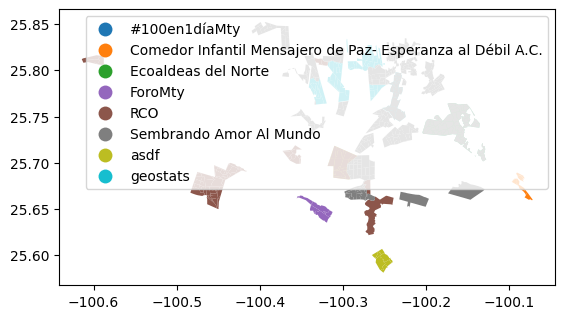

In [16]:
organization_regions_agebs = gpd.GeoDataFrame(
    organization_regions.join(agebs.set_index('sector_name'), on='sector_name', how='left'))
organization_regions_agebs = gpd.GeoDataFrame(
    organization_regions_agebs.join(organizations.set_index('name'), on='organization_name', how='left',
                                    rsuffix='organization')
)
organization_regions_agebs.plot('organization_name', legend=True)

In [17]:
organizations.to_pickle('../data/organizations.pkl')
organization_demographics.to_pickle('../data/organization_demographics.pkl')
organization_regions.to_pickle('../data/organization_regions.pkl')
organization_profiles.to_pickle('../data/organization_profiles.pkl')